---

In [2]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, log_loss


import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.inspection import DecisionBoundaryDisplay
import seaborn as sns

import time

---
---

# Modeling

---

In this part we will do some ML, implement different models to predict if a mail is a spam or not.

We will then process to a comparaison of the different models and conclude.

## Import the data

In [3]:
df = pd.read_csv("spambase_prep_norm.csv", sep=";", index_col="Unnamed: 0")
df

,make,address,all,3d,our,over,remove,internet,order,mail,...,;,(,[,!,$,#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spa
0,0.000000,0.195719,0.281938,0.0,0.108844,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.295705,0.000000,0.000000,0.063038,0.089820,0.090939,1.0
1,0.166667,0.085627,0.220264,0.0,0.047619,0.231405,0.107143,0.043210,0.000000,0.354717,...,0.000000,0.128155,0.0,0.141391,0.201342,0.062910,0.094099,0.149701,0.338955,1.0
2,0.047619,0.000000,0.312775,0.0,0.418367,0.157025,0.096939,0.074074,0.481203,0.094340,...,0.015504,0.138835,0.0,0.104903,0.205817,0.013106,0.201761,0.724551,0.746032,1.0
3,0.000000,0.000000,0.000000,0.0,0.214286,0.000000,0.158163,0.388889,0.233083,0.237736,...,0.000000,0.133010,0.0,0.052071,0.000000,0.000000,0.058028,0.058383,0.062169,1.0
4,0.000000,0.000000,0.000000,0.0,0.214286,0.000000,0.158163,0.388889,0.233083,0.237736,...,0.000000,0.131068,0.0,0.051311,0.000000,0.000000,0.058028,0.058383,0.062169,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4596,0.246032,0.000000,0.273128,0.0,0.000000,0.256198,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.225243,0.0,0.000000,0.000000,0.000000,0.003248,0.002994,0.028108,0.0
4597,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.134170,0.000000,0.000000,0.012694,0.004491,0.003638,0.0
4598,0.238095,0.000000,0.132159,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.158140,0.697087,0.0,0.000000,0.000000,0.000000,0.009241,0.007485,0.038029,0.0
4599,0.761905,0.000000,0.000000,0.0,0.108844,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.055340,0.0,0.000000,0.000000,0.000000,0.003362,0.005988,0.024802,0.0


## Split the data

In [4]:
def getTrainTest(data, p = 0.7, random_state=1, y=""):

    ''' 
    inputs :
    data        : dataframe
    p           : split between train and test sets
    randomstate : seed, only used for consistent results

    outputs :
    train_ : training set of proportion p
    test_  : testing set of proportion 1-p
    '''

    #names the target variable "y"
    data.rename(columns={f"{y}":"y"}, inplace=True)

    #split the data set in test and train
    train_ = data.sample(frac=p, random_state=random_state)
    test_  = data.drop(train_.index) 

    #get y and drops it for x
    train_y = train_.y
    train_x = train_.drop("y", axis=1)

    #get y and drops it for x
    test_y = test_.y
    test_x = test_.drop("y", axis=1)

    return train_x, train_y, test_x, test_y

In [5]:
train_x, train_y, test_x, test_y = getTrainTest(df, random_state=69, y="spa")

In [6]:
from sklearn.linear_model import LinearRegression 
from sklearn.linear_model import PoissonRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

In [7]:
def getModel(model_type = "linear"):
    ''' 
    inputs :
    model_type : model class  

    outputs : 
    model       : fitted model depending of model_type
    param_grid  : assiocated parameter grid for gridsearch
    '''
    if model_type == "linear":
        model = LinearRegression()
        param_grid = None

    elif model_type == "glm":
        model = PoissonRegressor()
        param_grid = ParameterGrid({
            "alpha":[[x] for x in np.linspace(0, 100, 3)],
            "max_iter":[[x] for x in np.random.randint(1, 1000, (3,))]
        })

    elif model_type == "bayesRidge":
        model = BayesianRidge()
        param_grid = ParameterGrid({
            "n_iter":[[x] for x in np.random.randint(100, 1000, 3)],
            "alpha_1":[[x] for x in np.linspace(1e-9, 1e-3, 3)],
            "alpha_2":[[x] for x in np.linspace(1e-9, 1e-3, 3)],
            "lambda_1":[[x] for x in np.linspace(1e-9, 1e-3, 3)],
            "lambda_2":[[x] for x in np.linspace(1e-9, 1e-3, 3)]
        })

    elif model_type == "randomForest":
        model = RandomForestClassifier()
        param_grid = ParameterGrid({
            "n_estimators":[[x] for x in np.random.randint(50, 150, 3)],
            "criterion":[["gini"],["entropy"],["log_loss"]],
            "max_depth":[[x] for x in np.random.randint(10, 500, (3,))],
            "max_features":[["sqrt"],["log2"]]
        })

    elif model_type == "KNN":
        model = KNeighborsClassifier()
        param_grid = ParameterGrid({
            "n_neighbors":[[x] for x in[1, 2, 3, 5, 10]],
            "weights":[["uniform"],["distance"]],
            "algorithm":[["auto"],["ball_tree"],["kd_tree"]],
            "p":[[x] for x in np.random.randint(1, 53, 3)]
        })

    elif model_type == "MLPCLassifier":
        model = MLPClassifier()
        param_grid = ParameterGrid({
            "hidden_layer_sizes":[(25,),(50,),(100,),(125,),(150,)],
            "activation": [[x] for x in ["identity", "logistic","tanh","relu"]],#note, this is dumb to set all layers to the same activation functions
            "solver":[[x] for x in ["lbfgs","sgd","adam"]]
        })
    
    else : 
        model = sklearn.linear_model.LinearRegression()
        param_grid = None

    return model, param_grid

In [8]:
def getSubBestModel(model, param_grid, X_train, y_train):
    classifier = GridSearchCV(model,
                                    param_grid=param_grid,
                                    # n_iter=10,
                                    cv=5,
                                    verbose=2,
                                    # random_state=420,
                                    n_jobs=-1
                                    )
    classifier.fit(X_train, y_train)
    return classifier.best_estimator_

In [9]:
models_names = [
    "MLPCLassifier",
    "linear",
    "glm",
    "bayesRidge",
    "randomForest",
    "KNN"
]

In [10]:
models = []
t = []

for mn in models_names:
    if mn != "linear":
        start = time.time()
        model, param_grid = getModel(mn)
        models += [getSubBestModel(model, param_grid=param_grid, X_train=train_x, y_train=train_y)]
        end = time.time()
        t += [end-start]
        print(f"{mn} model : Grid search done in {end-start} s.\n")

Fitting 5 folds for each of 60 candidates, totalling 300 fits


c:\Users\bapti\Cours TDs\S7\Python for Data Analysis\Projet-Python-S7\Projet-Python-S7\.env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPCLassifier model : Grid search done in 172.96100282669067 s.

Fitting 5 folds for each of 9 candidates, totalling 45 fits
glm model : Grid search done in 0.8582704067230225 s.

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
bayesRidge model : Grid search done in 5.430249929428101 s.

Fitting 5 folds for each of 54 candidates, totalling 270 fits
randomForest model : Grid search done in 27.841342210769653 s.

Fitting 5 folds for each of 90 candidates, totalling 450 fits
KNN model : Grid search done in 112.93598675727844 s.



In [11]:
lin, _ = getModel()
lin.fit(train_x, train_y)
models += [lin]

## Saving the models

In [14]:
import pickle

In [18]:
for m, mn in zip(models,models_names):
    filename=f"model-{mn}.joblib"
    pickle.dump(m, open(filename, 'wb'))

# Comparaison

In [58]:
def getAccLlog(model, test_x, test_y):
    prediction = model.predict(test_x)
    prediction = prediction > 0.5
    ll = log_loss(test_y, prediction)
    acc = accuracy_score(test_y, prediction)
    return ll, acc

In [59]:
conf_mats = []
for m in models:
    conf_mats += [getAccLlog(m, test_x, test_y)]

In [62]:
results = pd.DataFrame()
results["model"] = models_names
results = results.join(pd.DataFrame( np.array(conf_mats).reshape((6,2)).tolist(),
                        columns=["log loss", "accuracy"]))
results["time"] = t[:1] + [0] + t[1:]


In [63]:
results.sort_values(["log loss","accuracy"], inplace=True)
results

,model,log loss,accuracy,time
3,bayesRidge,1.576785,0.954348,4.768963
0,MLPCLassifier,1.802043,0.947826,156.859636
2,glm,3.128531,0.909420,0.827297
5,KNN,3.178589,0.907971,100.986413
1,linear,3.328754,0.903623,0.000000
4,randomForest,3.328783,0.903623,125.894806


## Comparaison Plots

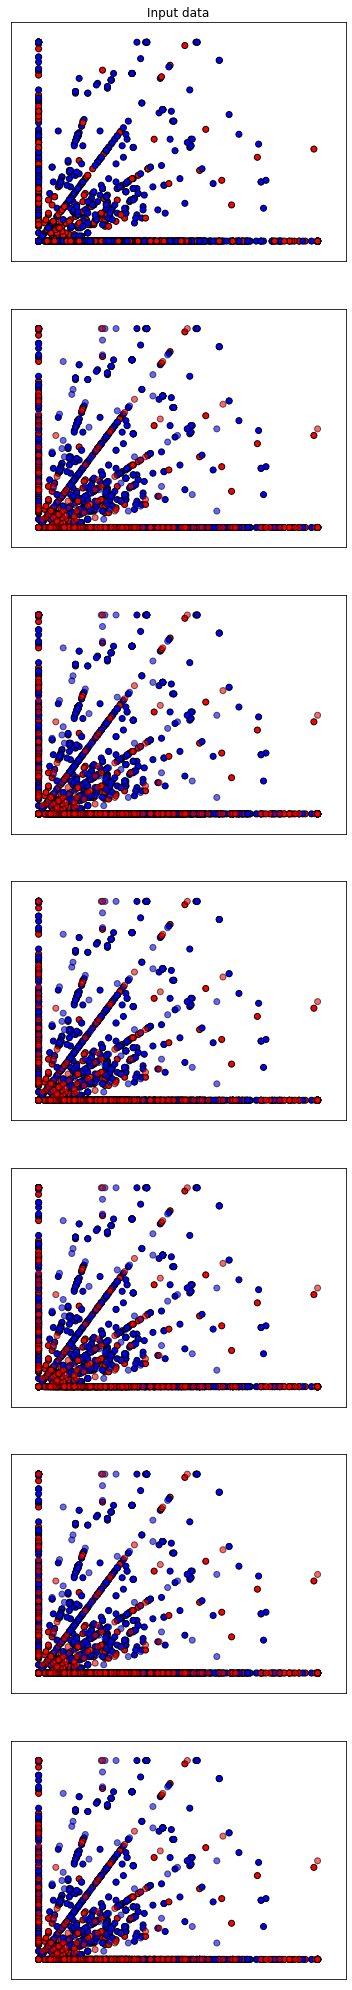

In [44]:
n1, n2 = 2, 5

i = 0

figure = plt.figure(figsize=(3*2, 18*2))

x_min, x_max = -0.1, 1.1
y_min, y_max = -0.1, 1.1

cm = plt.cm.RdBu
cm_bright = ListedColormap(["#FF0000","#0000FF"])

ax = plt.subplot(len(models)+1, 1, 1)
i += 1
ax.set_title("Input data")
ax.scatter(train_x.T[n1:n1+1], train_x.T[n2:n2+1], c=train_y, cmap=cm_bright, edgecolors = "k")

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xticks(())
ax.set_yticks(())

for name, clf in zip(models_names, models):
    ax = plt.subplot( len(models)+1, 1, i+1)
    i+= 1

    #plot the training points
    ax.scatter(
        train_x.T[n1:n1+1], train_x.T[n2:n2+1], c=train_y, cmap=cm_bright, edgecolors="k"
    )

    #plot the testing points
    ax.scatter(
        test_x.T[n1:n1+1], test_x.T[n2:n2+1], c=test_y, cmap=cm_bright, edgecolors="k", alpha=0.6
    )

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())

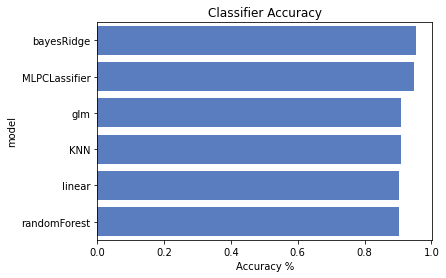

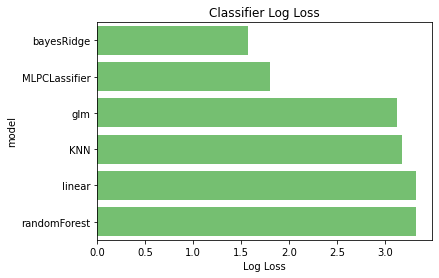

In [64]:
sns.set_color_codes("muted")
sns.barplot(data=results, x="accuracy", y="model", color="b")

plt.xlabel('Accuracy %')
plt.title('Classifier Accuracy')
plt.show()

sns.set_color_codes("muted")
sns.barplot(data=results, x='log loss', y='model', color="g")

plt.xlabel('Log Loss')
plt.title('Classifier Log Loss')
plt.show()

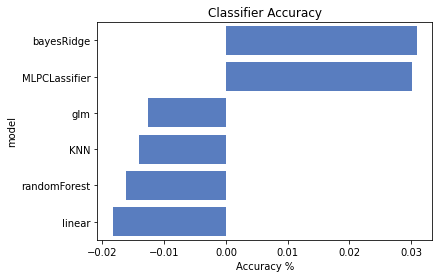

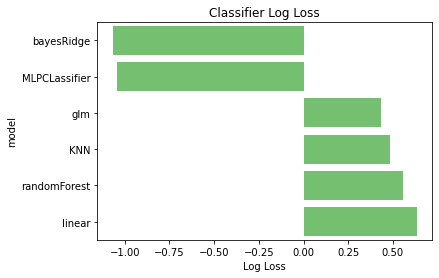

In [46]:
dresults = -(results[["log loss", "accuracy"]].mean() - results[["log loss", "accuracy"]])
dresults["model"] = results["model"]

sns.set_color_codes("muted")
sns.barplot(data=dresults, x="accuracy", y="model", color="b")

plt.xlabel('Accuracy %')
plt.title('Classifier Accuracy')
plt.show()

sns.set_color_codes("muted")
sns.barplot(data=dresults, x='log loss', y='model', color="g")

plt.xlabel('Log Loss')
plt.title('Classifier Log Loss')
plt.show()

In [67]:
results["log time"] = results["time"].apply(lambda x : np.log(x+1))
px.scatter(results, x="log loss", y="accuracy", hover_data=['model'], title="Log loss against accuracy", color="log time")

txt ="We can deduce that the Machine Learning Algorithm is just as good as the BayesRidge model. They have casi exact accuracy and log loss. This means that they cluster about the same way points. It would be interesting to look under the hood and maybe dive deeper why they behave such."

In [19]:
txt ="We can deduce that the Machine Learning Algorithm is just as good as the BayesRidge model. They have casi exact accuracy and log loss. This means that they cluster about the same way points. It would be interesting to look under the hood and maybe dive deeper why they behave such."

In [21]:
import re

In [22]:
re.split(', |_|-|!', txt)

['We',
 'can',
 'deduce',
 'that',
 'the',
 'Machine',
 'Learning',
 'Algorithm',
 'is',
 'just',
 'as',
 'good',
 'as',
 'the',
 'BayesRidge',
 'model.',
 'They',
 'have',
 'casi',
 'exact',
 'accuracy',
 'and',
 'log',
 'loss.',
 'This',
 'means',
 'that',
 'they',
 'cluster',
 'about',
 'the',
 'same',
 'way',
 'points.',
 'It',
 'would',
 'be',
 'interesting',
 'to',
 'look',
 'under',
 'the',
 'hood',
 'and',
 'maybe',
 'dive',
 'deeper',
 'why',
 'they',
 'behave',
 'such.']